#Fitting Functions, Part 2

##Fitting straight lines, part 2: the weighted least squares fit

Many physics experiments do produce results that can be expressed as straight lines, but for which the errors on the different points are not the same.  For example, radioactive decay,
$$
N(t) = N_0 e^{-\lambda t}
$$
can be written in the form
$$
\ln N(t) = \ln N_0 - \lambda t,
$$
which is a straight line with gradient $-\lambda$ and intercept $\ln N_0$.  However, as radioactive decay is a random process, $N(t)$ will follow a Poisson distribution and will therefore have standard deviation $\sqrt{N}$.  Assuming $N\gg 1$, we therefore have an error on $\ln N$ of
$$
\sigma_{\ln N} = \frac{\sigma_N}{N} = \frac{1}{\sqrt{N}},
$$
i.e. we cannot treat all the points as having the same uncertainty.

The way to tackle this is to **weight** the data points so that those with larger error bars contribute less to the fit.
We can see what the appropriate weight ought to be by considering a set of $N$ normally distributed measurements with mean $\mu$ and standard deviation $\sigma$.  The uncertainty in the mean is then $\bar{\sigma}=\sigma/\sqrt{N}$. If we split the dataset up into two subsets, one with $n_1$ measurements and mean $\mu_1\pm\sigma_1$ and the other with $n_2$ measurements and mean $\mu_2\pm\sigma_2$, then $\sigma_1 = \sigma/\sqrt{n_1}$ and $\sigma_2 = \sigma/\sqrt{n_2}$.  Obviously
$$
N\mu = n_1\mu_1 + n_2\mu_2.
$$

If we didn't know $N$, $n_1$ and $n_2$, but only had $\mu_1\pm\sigma_1$ and $\mu_2\pm\sigma_2$, we could recover the correct combined result, $\mu\pm\bar{\sigma}$, by using

$$
\begin{aligned}
\mu &= \frac{n_1/\sigma_1^2 + n_2/\sigma_2^2}{1/\sigma_1^2 + 1/\sigma_2^2} 
= \frac{(n_1\mu_1 + n_2\mu_2)/\sigma^2}{(n_1+n_2)/\sigma^2}\\
\frac{1}{\bar{\sigma}^2} &= \frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2} = \frac{n_1+n_2}{\sigma^2}
\end{aligned}
$$
(cancel off the factors of $\sigma^2$ and write $N=n_1+n_2$, and you get back our original result).

This indicates that we should weight data points with different error bars by $1/\sigma_i^2$, where $\sigma_i$ is the uncertainty of the $i^{\mathrm{th}}$ data point.  This gives the definition of the **weighted mean**
$$
\begin{aligned}
\bar{x} &= \frac{\sum_i x_i/\sigma_i^2}{\sum_i 1/\sigma_i^2}\\
\frac{1}{\bar{\sigma}^2} &= \sum_i \frac{1}{\sigma_i^2}
\end{aligned}
$$
which is used for combining measurements of the same quantity, $x_i$, that have different error bars, $\sigma_i$.

In fitting the straight line $y=mx+c$, the same logic indicates that we should be trying to minimise
$$
\chi^2(m,c) = \sum_i \frac{(y_i-mx_i-c)^2}{\sigma_i^2},
$$
i.e. the square of the difference between the data point and the fitted value, *in units of the data point's error bar*.
This distribution is called $\chi^2$ ("chi squared"), and a fit that minimises it is usually called a $\chi^2$ fit.

Deriving the appropriate expressions for the weighted least-squares fit is not difficult (they are given in [PyMan chapter 7](http://clouds.eos.ubc.ca/~phil/djpine_python/Book/_build/html/chap7/chap7_funcs.html)), but we have now reached the point at which it is sensible to give up on DIY and wheel in the ready-made artillery.  The SciPy package provides a curve fitter called, not entirely surprisingly, [**curve_fit**](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html), which does a $\chi^2$ fit to an arbitrary function $f(x)$.

True values: lambda = -0.0700 , ln(N0) =  4.605
Unweighted fit: lambda = -0.0712 ±  0.0064 , ln(N0) =  4.551 ±  0.224
curve_fit: lambda = -0.0646 ±  0.0033 , ln(N0) =  4.509 ±  0.058


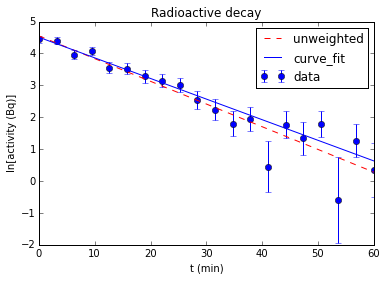

In [44]:
%matplotlib inline

#Example of using curve_fit to fit a straight line with unequally weighted points
import numpy as np
import scipy.optimize as spopt
import matplotlib.pyplot as plt

#Define an ordinary, unweighted least squares fit
def linest(x,y):
    xmean = x.mean()
    m = ((x-xmean)*y).sum()/((x-xmean)*x).sum()
    c = y.mean()-m*xmean
    yfit = m*x + c
    varm = (y*y-2*y*yfit+yfit*yfit).sum()/((x-xmean)*x).sum()/(len(x)-2)
    varc = varm*(x*x).mean()
    return m,c,varm,varc

#Define a straight line for curve_fit
def flin(x,m,c):
    return m*x+c

#generate some simulated data for a radioactive decay 

tmin = 0.0
tmax = 60.0
nbins = 20
n0 = 100
lam = 0.07
lnn0 = np.log(n0)
print('True values: lambda = -%6.4f'%lam,', ln(N0) = %6.3f'%lnn0)

tdata = np.linspace(tmin,tmax,nbins)
scatter = np.random.normal(0.0,1.0,nbins) #Gaussian distribution with mean 0 and variance 1
ntrue = n0*np.exp(-lam*tdata)
ndata = ntrue+np.sqrt(ntrue)*scatter
logndata = np.where(ndata>0,np.log(ndata),-1.0)  #use np.where to protect against trying to take ln(0)
lognerror = np.where(ndata>0,np.sqrt(ndata)/ndata,1.0) #and to protect against /0 or sqrt(<0)

#fit these data using unweighted least squares and curve_fit

lamunw,lnnunw,varlam,varn0 = linest(tdata,logndata) #unweighted fit
siglam = np.sqrt(varlam)
siglnn = np.sqrt(varn0)

print('Unweighted fit: lambda = %7.4f'%lamunw,"\u00b1",'%7.4f'%siglam,', ln(N0) = %6.3f'%lnnunw,"\u00b1",'%6.3f'%siglnn)

popt,pcov = spopt.curve_fit(flin,tdata,logndata,sigma=lognerror)
sigma = np.sqrt(np.diag(pcov))

print('curve_fit: lambda = %7.4f'%popt[0],"\u00b1",'%7.4f'%sigma[0],', ln(N0) = %6.3f'%popt[1],"\u00b1",'%6.3f'%sigma[1])

plt.errorbar(tdata,logndata,yerr=lognerror,fmt='bo',label='data')
plt.plot(tdata,lamunw*tdata+lnnunw,'r--',label='unweighted')
plt.plot(tdata,popt[0]*tdata+popt[1],'b',label='curve_fit')
plt.legend(loc=0)
plt.title('Radioactive decay')
plt.xlabel('t (min)')
plt.ylabel('ln[activity (Bq)]')

The unweighted fit is more affected by the points at large $t$, which have large error bars and therefore have little effect on **curve_fit**.  The greater scatter of these points inflates the uncertainties on the fitted parameters, even though the central values are not severely compromised.

##Linear and non-linear fits

The **curve_fit** routine will fit *any* function $f(x)$, not just $f(x) = mx + c$.  However, there is a big difference in statistics between **linear** and **non-linear** fits.

###Linear fits
To a statistician, a linear fit is *not* a fit to a straight line.  It refers to a function which is linear **in its parameters**, not in the independent variable $x$.  So, for example,

* $f(x) = a_0 + a_1 x + a_2 x^2 + a_3 x^3$ is linear;
* $f(x) = a_0 + \frac{x}{a_1}$ is non-linear (though it could be made linear by defining $a'_1=1/a_1$ and fitting $(a_0,a'_1)$ instead of $(a_0,a_1)$);
* $f(x) = a_0(1 + a_1 x)$ is non-linear (though it could be made linear by defining $a_1'=a_0a_1$);
* $f(x) = a_0 \sin(\omega x)$, where $\omega$ is a fixed constant, is linear, but
* $f(x) = a_0 \sin(a_1 x)$, where $a_1$ is a fit parameter, is not.

This may not seem like much, but in fact it is a critically important distinction.  Linear fits can be solved analytically:
taking partial derivatives of $\chi^2(a_0,a_1,...)$ with respect to each of the parameters $a_0,a_1,...$ will give a tractable set of simultaneous equations which you could in principle solve to get the best fit (if the linear function is complicated, solving the simultaneous equations might be long and tedious, but it is *possible*).  This is because $\chi^2$ is quadratic in parameter $a_i$, so its partial derivative $\partial\chi^2/\partial a_i$ is linear in $a_i$. 

As a result of this, the multidimensional surface described by $\chi^2(a_0,a_1,...)$ is well-behaved, with a single global minimum representing the best fit.  If you use an iterative fitting routine like **curve_fit**, it does not matter what initial guesses you give it for the parameter values (in the above example, we didn't give it any &ndash; this means they all defaulted to 1.0): it will always converge on the correct minimum.

###Non-linear fits
Non-linear fits involve functions that are *not* linear in the parameters.  The Gaussian for a sample of $N$ events,

$$
f(x;N,\mu,\sigma^2) = \frac{N}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right),
$$

is not linear in its parameters $\mu$ and $\sigma^2$, and cannot be made so.

Non-linear fits do not in general have neat analytic solutions, and the $\chi^2$ fit is not guaranteed to succeed.  In particular, it is possible for the $\chi^2$ surface to have **local minima** in which iterative fits can become trapped.
The fit is often sensitive to the choice of starting parameters: it may succeed for some initial guesses and fail for others.

Fitted Gaussian: N = 979.33 ±  29.01 , mu = 14.85 ±  0.29 , sigma = 9.610 ± 0.213
The correlation matrix is
[[  1.088e+03   1.924e-02   6.030e-02]
 [  1.924e-02   2.025e-02   2.217e-04]
 [  6.030e-02   2.217e-04   1.108e-02]]


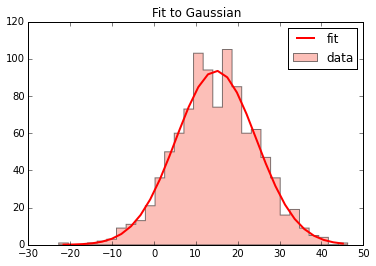

In [112]:
%matplotlib inline

import numpy as np
import scipy.optimize as spopt
import matplotlib.pyplot as plt

def Ngaussian(x,N,mu,sigma): #Gaussian for N events
    return N*np.exp(-0.5*np.power((x-mu)/sigma,2))/(np.sqrt(2*np.pi)*sigma)

mu = 15
sigma = 10
N = 1000

data=np.random.normal(mu,sigma,N)

counts,bins,patches = plt.hist(data,30,normed=False,histtype='stepfilled',facecolor='salmon',alpha=0.5,label='data')
xdata = np.zeros(30)
for i in range(len(xdata)):
    xdata[i]=0.5*(bins[i]+bins[i+1])  #xdata is the bin centrees
errors = np.where(counts>0,np.sqrt(counts),1.0) #assigns error +/- 1 to any empty bins
binwidth = bins[1]-bins[0]  #number of events in bin is P(x)dx, so will need to correct fitted N for binwidth

popt,pcov = spopt.curve_fit(Ngaussian,xdata,counts,sigma=errors)
sigma = np.sqrt(np.diag(pcov))
#correct N for bin width
Nfit = popt[0]/binwidth
sigNfit = sigma[0]/binwidth
print('Fitted Gaussian: N = %6.2f'%Nfit,"\u00b1",'%6.2f'%sigNfit,', mu = %5.2f'%popt[1],"\u00b1",'%5.2f'%sigma[1],', sigma = %5.3f'%popt[2],"\u00b1",'%5.3f'%sigma[2])
print('The correlation matrix is') 
np.set_printoptions(precision=3)
pcorr=pcov/np.prod(sigma)
print(pcorr)

plt.plot(xdata,Ngaussian(xdata,popt[0],popt[1],popt[2]),'r',linewidth=2,label='fit')
plt.title('Fit to Gaussian')
plt.legend(loc=0)

The fit to a Gaussian is actually quite well-behaved: even though we put in no initial guesses, and the true values are far from 1.0, it converges to sensible results.

Fitted Gaussian 1: N = 669.20 ±  40.10 , mu =  0.22 ±  0.53 , sigma = 10.900 ± 0.567
Fitted Gaussian 1: N = 319.69 ±  35.08 , mu =  6.09 ±  2.41 , sigma = 38.308 ± 2.401
The correlation matrix is
[[  6.536e-01   4.972e-05   4.967e-04  -3.754e-01   8.578e-04   2.228e-03]
 [  4.972e-05   1.265e-06   3.001e-08  -4.936e-05  -9.001e-07   3.699e-07]
 [  4.967e-04   3.001e-08   1.428e-06  -4.896e-04   1.014e-06   2.654e-06]
 [ -3.754e-01  -4.936e-05  -4.896e-04   5.001e-01  -8.213e-04  -2.148e-03]
 [  8.578e-04  -9.001e-07   1.014e-06  -8.213e-04   2.586e-05   6.765e-06]
 [  2.228e-03   3.699e-07   2.654e-06  -2.148e-03   6.765e-06   2.565e-05]]


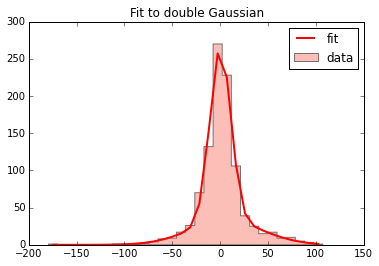

In [111]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as spopt

def dblegaus(x,N1,mu1,sig1,N2,mu2,sig2):
    return N1*np.exp(-0.5*np.power((x-mu1)/sig1,2))/(np.sqrt(2*np.pi)*sig1)+N2*np.exp(-0.5*np.power((x-mu2)/sig2,2))/(np.sqrt(2*np.pi)*sig2)

N1 = 700
mu1 = 0.0
sig1 = 10.0 

N2 = 300
mu2 = 5.0
sig2 = 40.0

data1=np.random.normal(mu1,sig1,N1)
data2=np.random.normal(mu2,sig2,N2)
data=np.concatenate((data1,data2))

counts,bins,patches = plt.hist(data,30,normed=False,histtype='stepfilled',facecolor='salmon',alpha=0.5,label='data')
xdata = np.zeros(30)
for i in range(len(xdata)):
    xdata[i]=0.5*(bins[i]+bins[i+1])  #xdata is the bin centrees
errors = np.where(counts>0,np.sqrt(counts),1.0) #assigns error +/- 1 to any empty bins
binwidth = bins[1]-bins[0]  #number of events in bin is P(x)dx, so will need to correct fitted N for binwidth

popt,pcov = spopt.curve_fit(dblegaus,xdata,counts,sigma=errors,absolute_sigma=True,p0=[1000,1,1,100,1,10])
sigma = np.sqrt(np.diag(pcov))
#correct N for bin width
N1fit = popt[0]/binwidth
sigN1fit = sigma[0]/binwidth
N2fit = popt[3]/binwidth
sigN2fit = sigma[3]/binwidth
print('Fitted Gaussian 1: N = %6.2f'%N1fit,"\u00b1",'%6.2f'%sigN1fit,', mu = %5.2f'%popt[1],"\u00b1",'%5.2f'%sigma[1],', sigma = %5.3f'%popt[2],"\u00b1",'%5.3f'%sigma[2])
print('Fitted Gaussian 1: N = %6.2f'%N2fit,"\u00b1",'%6.2f'%sigN2fit,', mu = %5.2f'%popt[4],"\u00b1",'%5.2f'%sigma[4],', sigma = %5.3f'%popt[5],"\u00b1",'%5.3f'%sigma[5])
pcorr=pcov/np.prod(sigma)
print('The correlation matrix is') 
np.set_printoptions(precision=3)
print(pcorr)
plt.plot(xdata,dblegaus(xdata,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5]),'r',linewidth=2,label='fit')
plt.title('Fit to double Gaussian') 
plt.legend(loc=0)

On the other hand, the fit to the sum of two Gaussians will sometimes die horribly if you don't give it plausible starting parameters.  It does better if the two Gaussians are well separated.  Notice that the fitted parameters are very correlated (the off-diagonal elements of the covariance matrix are comparable to the on-diagonal elements).  [Note: because of the way I defined the function, occasionally the fit converges to negative values for both $N$ and $\sigma$: these cancel.  If only one is negative, it really does believe that the best fit subtracts events instead of adding them.]

(I did try using a Cauchy distribution to demonstrate this, but it's so pathological that it fell over essentially every time.  Try it for yourself!  NumPy provides a Cauchy-distributed random number generator.)

##Summary

The SciPy routine **curve_fit** can be used to fit arbitrary functions, both linear and non-linear in the parameters.  In the case of non-linear fits,

* you may have to set the initial guesses p0 fairly carefully to get a successful fit, and
* it is possible for the fit to converge on a local minimum instead of the true best fit.

In all cases, it is very useful to check your data visually before embarking on a fitting procedure.  Check for effects such as saturation (an initially linear relationship flattens out), offsets (a relationship that should go through the origin doesn't) and outliers (one or two points are clearly a *very* long way from the rest of the pack).  If you have copied your data down by hand at any point, the most likely reason for outliers is a typo: 1.9 got recorded as 9.1, for example.  Although it is often OK to discard outliers, always clearly record that you have done so, and do not be too zealous: remember that one point in 20 *should* be more than two error bars off the best fit!